In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import griddata

In [2]:
df = pd.read_csv('force_obs/suzaku_1.5EF20deg_force.csv')

In [3]:
time, X_F, Y_F, N_F, psi = df['time'], df['X_F'], df['Y_F'], df['N_F'], df['psi']

In [4]:
# df = pd.read_csv('force_obs/suzaku_1.5EF20deg_force_target.csv')
# time, X_F, Y_F, N_F, psi = df['time'], df['X_F_target'], df['Y_F_target'], df['N_F_target'], df['psi']

In [5]:
angle_bins = np.arange(0, 360, 1)  # 1°刻み
data = {}

for angle in angle_bins:
    # 角度angleにおける外力の大きさを計算
    force_magnitude = X_F * np.cos(np.radians(angle)) + Y_F * np.sin(np.radians(angle))
    data[angle] = force_magnitude

# データフレームとして保存し、CSVに出力
df = pd.DataFrame(data)
df.to_csv("force_obs/force_data_by_angle.csv")

In [6]:
df = pd.read_csv('force_obs/force_data_by_angle.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-6.477558,-6.387753,-6.296002,-6.202334,-6.106776,-6.009358,-5.910109,-5.809061,-5.706242,-5.601686,...,-7.262875,-7.193930,-7.122795,-7.049489,-6.974036,-6.896459,-6.816781,-6.735027,-6.651221,-6.565389
2,-8.147278,-8.237218,-8.324648,-8.409543,-8.491875,-8.571622,-8.648757,-8.723257,-8.795101,-8.864265,...,-7.116276,-7.229679,-7.340878,-7.449842,-7.556537,-7.660930,-7.762989,-7.862683,-7.959983,-8.054857
3,-2.341306,-2.333298,-2.324580,-2.315153,-2.305021,-2.294187,-2.282654,-2.270426,-2.257507,-2.243899,...,-2.381864,-2.381062,-2.379534,-2.377282,-2.374305,-2.370606,-2.366184,-2.361041,-2.355180,-2.348600
4,-1.605276,-1.571561,-1.537368,-1.502706,-1.467587,-1.432021,-1.396018,-1.359590,-1.322748,-1.285504,...,-1.913909,-1.885521,-1.856559,-1.827031,-1.796946,-1.766314,-1.735144,-1.703445,-1.671228,-1.638502


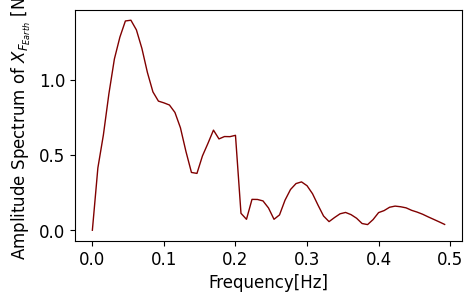

In [7]:
x_mean = df['0'] - np.mean(df['0'])
F_x = np.fft.fft(x_mean)
N = len(df)
freq = np.fft.fftfreq(N, d=1)
F_x = F_x / (N / 2)
Amp_x = np.abs(F_x)
fig = plt.figure(figsize=(5, 3))
plt.plot(freq[:int(N/2)], Amp_x[:int(N/2)], c = 'maroon', linewidth=1)
plt.xlabel('Frequency[Hz]', fontsize=12)
plt.ylabel('Amplitude Spectrum of $X_{F_{Earth}}$ [N]', fontsize=12)
plt.tick_params(labelsize=12)

In [ ]:
# サンプリング周波数（Hz）を設定
sampling_rate = 1.0  # 必要に応じて適切な値に変更（例: 1 Hz）

# 各角度ごとにFFTを実行し、周波数成分とその強度を取得
angle_fft_data = {}
max_amplitude_angle = None
max_amplitude = 0

for angle in range(360):
    # 各角度の外力時系列データを取得
    force_series = df[str(angle)]
    
    # FFTを計算
    mean = force_series - np.mean(force_series)
    F = np.fft.fft(mean)
    N = len(force_series)
    freq = np.fft.fftfreq(N, d=1/sampling_rate)
    F = F / (N / 2)
    Amp_x = np.abs(F)
    
    # 周波数0を除いた最大強度を見つける
    peak_amplitude = np.max(Amp_x[1:int(N/2)])  # 直流成分（0Hz）は除外
    if peak_amplitude > max_amplitude:
        max_amplitude = peak_amplitude
        max_amplitude_angle = angle  # 最大強度の角度を基準角度とする
    
    # 結果をデータフレームに格納
    angle_fft_data[f"{angle}_freq"] = freq[:int(N/2)]
    angle_fft_data[f"{angle}_amplitude"] = Amp_x[:int(N/2)]
    
max_amplitude_angle += 180
print(f"最大強度の角度: {max_amplitude_angle}°")

# 基準角度から±90°に近い成分のみを残す
for angle in range(360):
    angle_diff = (angle - max_amplitude_angle) % 360
    if angle_diff > 180:
        angle_diff = 360 - angle_diff
    
    # ±90°を超える角度の成分は0にする
    if angle_diff > 90:
        # angle_fft_data[f"{angle}_amplitude"] = np.zeros_like(angle_fft_data[f"{angle}_amplitude"])
        angle_fft_data[f"{angle}_amplitude"] = angle_fft_data[f"{angle}_amplitude"] * 0.1

# 結果をデータフレームにまとめる
fft_df = pd.DataFrame(angle_fft_data)

# CSVに保存
fft_df.to_csv("force_obs/fft_by_angle.csv", index=False)

最大強度の角度: 194°


In [11]:
fft_df = pd.read_csv('force_obs/fft_by_angle.csv')
fft_df.head()

,0_freq,0_amplitude,1_freq,1_amplitude,2_freq,2_amplitude,3_freq,3_amplitude,4_freq,4_amplitude,...,355_freq,355_amplitude,356_freq,356_amplitude,357_freq,357_amplitude,358_freq,358_amplitude,359_freq,359_amplitude
0,0.000000,2.732857e-17,0.000000,3.825999e-17,0.000000,2.732857e-17,0.000000,2.186285e-17,0.000000,5.465713e-18,...,0.000000,1.093143e-17,0.000000,2.186285e-17,0.000000,3.825999e-17,0.000000,1.093143e-17,0.000000,3.279428e-17
1,0.007692,4.145451e-02,0.007692,4.110744e-02,0.007692,4.074965e-02,0.007692,4.038129e-02,0.007692,4.000255e-02,...,0.007692,4.302410e-02,0.007692,4.273274e-02,0.007692,4.242998e-02,0.007692,4.211593e-02,0.007692,4.179073e-02
2,0.015385,6.336963e-02,0.015385,6.345089e-02,0.015385,6.351598e-02,0.015385,6.356486e-02,0.015385,6.359752e-02,...,0.015385,6.272226e-02,0.015385,6.288369e-02,0.015385,6.302921e-02,0.015385,6.315874e-02,0.015385,6.327223e-02
3,0.023077,9.073759e-02,0.023077,9.113055e-02,0.023077,9.149668e-02,0.023077,9.183585e-02,0.023077,9.214796e-02,...,0.023077,8.837533e-02,0.023077,8.890026e-02,0.023077,8.939912e-02,0.023077,8.987173e-02,0.023077,9.031794e-02
4,0.030769,1.139762e-01,0.030769,1.144260e-01,0.030769,1.148412e-01,0.030769,1.152215e-01,0.030769,1.155670e-01,...,0.030769,1.112127e-01,0.030769,1.118335e-01,0.030769,1.124204e-01,0.030769,1.129732e-01,0.030769,1.134919e-01


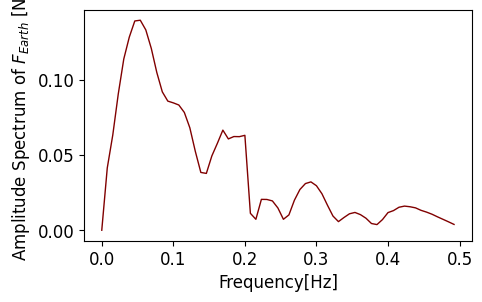

In [12]:
fig = plt.figure(figsize=(5, 3))
plt.plot(fft_df['0_freq'], fft_df['0_amplitude'], c = 'maroon', linewidth=1)
plt.xlabel('Frequency[Hz]', fontsize=12)
plt.ylabel('Amplitude Spectrum of $F_{Earth}$ [N]', fontsize=12)
plt.tick_params(labelsize=12)

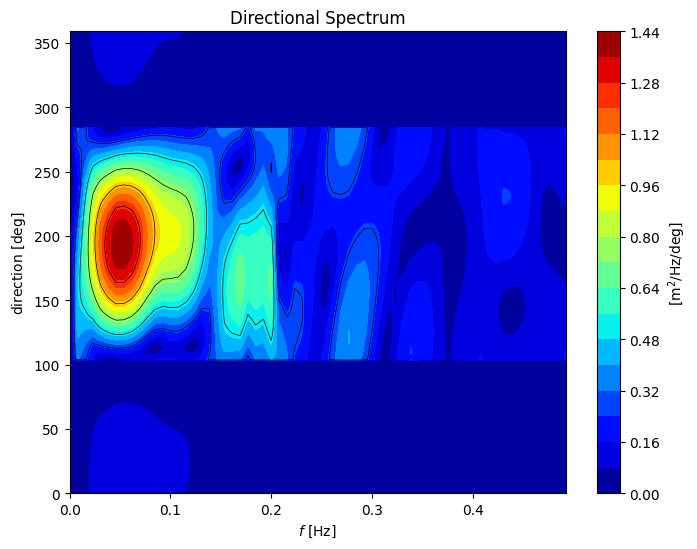

In [13]:
from matplotlib.colors import LinearSegmentedColormap
# FFT結果のCSVデータを読み込み
fft_df = pd.read_csv("force_obs/fft_by_angle.csv")

# 角度と周波数の範囲を設定
angles = np.arange(0, 360, 1)  # 角度 (0°から359°)
frequencies = fft_df[f"{angles[0]}_freq"].values  # 周波数

# スペクトル強度を取得し、角度と周波数のメッシュグリッドを生成
spectral_data = np.array([fft_df[f"{angle}_amplitude"].values for angle in angles])
angle_grid, freq_grid = np.meshgrid(angles, frequencies)

# 等高線プロットを作成
plt.figure(figsize=(8, 6))
contour = plt.contourf(freq_grid, angle_grid, spectral_data.T, levels=20, cmap=cm.jet)
cbar = plt.colorbar(contour)
cbar.set_label(r"$\mathrm{[m^2/Hz/deg]}$")

# 軸ラベルとタイトル
plt.xlabel(r"$f\ \mathrm{[Hz]}$")
plt.ylabel(r"$\mathrm{direction\ [deg]}$")
plt.title("Directional Spectrum")

# 等高線のラベルを追加
plt.contour(freq_grid, angle_grid, spectral_data.T, colors='black', levels=5, linewidths=0.5)

# グラフを表示
plt.show()